In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np


import torch.nn.functional as F

In [8]:
class SimpleNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),

            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(784, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [9]:
def calculate_metrics(loader: DataLoader, model: nn.Module):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=True, download=True, transform=transform)
valset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)


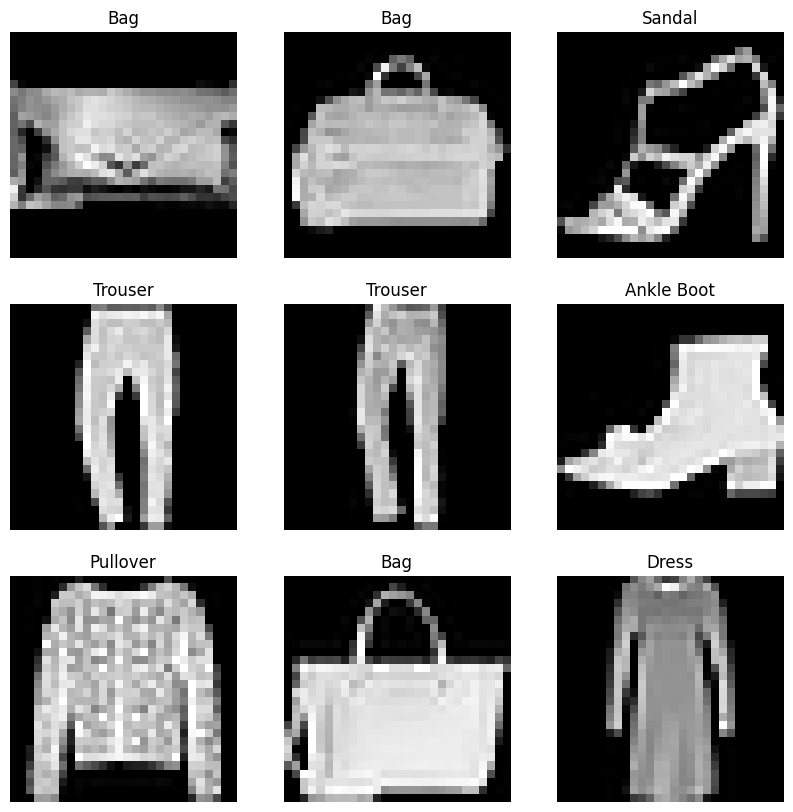

In [11]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(trainset), size = (1,)).item()
    image, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [12]:
net = SimpleNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)

val_acc, val_rec, val_prec, val_f1 =0,0,0,0
epoch = 0



net_losses = []

net_accuracies_train = []
net_recalls_train = []
net_precisions_train = []
net_f1_train = []

net_accuracies_val = []
net_recalls_val = []
net_precisions_val = []
net_f1_val = []



while val_acc < 0.91 and val_rec <0.91 and val_prec < 0.91 and val_f1 < 0.91:
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss:nn.CrossEntropyLoss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}')

    train_acc, train_rec, train_prec, train_f1 = calculate_metrics(trainloader, net)
    print(f'Training - Accuracy: {train_acc}, Recall: {train_rec}, Precision: {train_prec}, F1 Score: {train_f1}')

    val_acc, val_rec, val_prec, val_f1 = calculate_metrics(valloader, net)
    print(f'Validation - Accuracy: {val_acc}, Recall: {val_rec}, Precision: {val_prec}, F1 Score: {val_f1}')


    net_losses.append(running_loss / len(trainloader))
    
    net_accuracies_train.append(train_acc)
    net_recalls_train.append(train_rec)
    net_precisions_train.append(train_prec)
    net_f1_train.append(train_f1)

    net_accuracies_val.append(val_acc)
    net_recalls_val.append(val_rec)
    net_precisions_val.append(val_prec)
    net_f1_val.append(val_f1)

    epoch+=1

print('Finished Training')

Epoch 1, Loss: 1.602
Training - Accuracy: 0.7059833333333333, Recall: 0.7059833333333334, Precision: 0.7047064826688973, F1 Score: 0.6941208438701232
Validation - Accuracy: 0.7058, Recall: 0.7058000000000001, Precision: 0.703759685662828, F1 Score: 0.6941178497775768
Epoch 2, Loss: 0.961
Training - Accuracy: 0.74295, Recall: 0.7429500000000001, Precision: 0.7366659043055137, F1 Score: 0.7337774980022082
Validation - Accuracy: 0.7385, Recall: 0.7384999999999999, Precision: 0.7298273257185001, F1 Score: 0.7289401659822109
Epoch 3, Loss: 0.806
Training - Accuracy: 0.7634, Recall: 0.7634000000000001, Precision: 0.7584139878042422, F1 Score: 0.7591709066979416
Validation - Accuracy: 0.7569, Recall: 0.7569, Precision: 0.7525625474997175, F1 Score: 0.7534558687875241
Epoch 4, Loss: 0.740
Training - Accuracy: 0.7764166666666666, Recall: 0.7764166666666666, Precision: 0.773292161887139, F1 Score: 0.7733506416448445
Validation - Accuracy: 0.7682, Recall: 0.7682, Precision: 0.765927709682509, F1 

KeyboardInterrupt: 

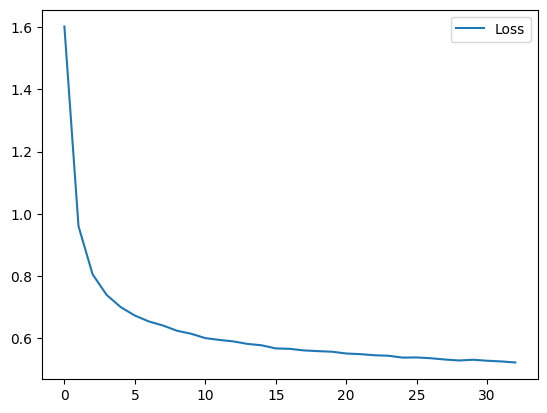

In [13]:
plt.plot(list(range(len(net_losses))), net_losses, label='Loss')
plt.legend()

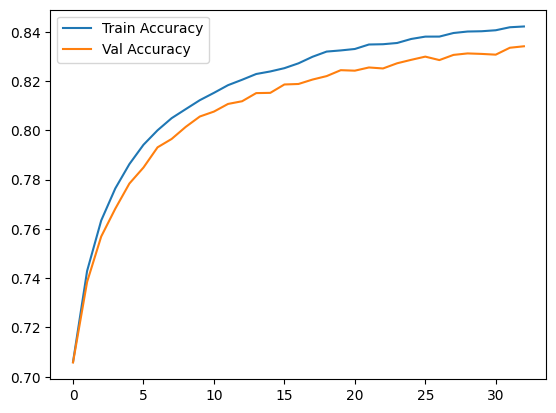

In [14]:
plt.plot(list(range(len(net_accuracies_train))), net_accuracies_train, label='Train Accuracy')
plt.plot(list(range(len(net_accuracies_val))), net_accuracies_val, label='Val Accuracy')
plt.legend()

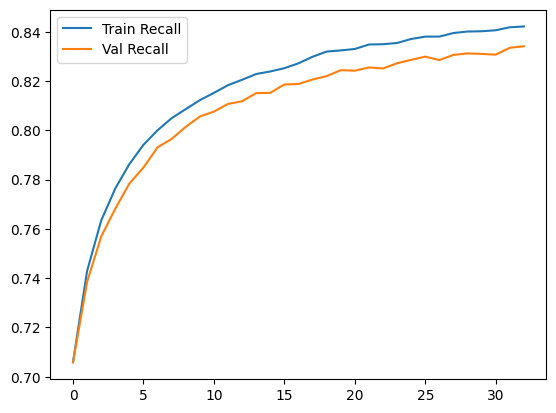

In [15]:
plt.plot(list(range(len(net_recalls_train))), net_recalls_train, label='Train Recall')
plt.plot(list(range(len(net_recalls_val))), net_recalls_val, label='Val Recall')
plt.legend()

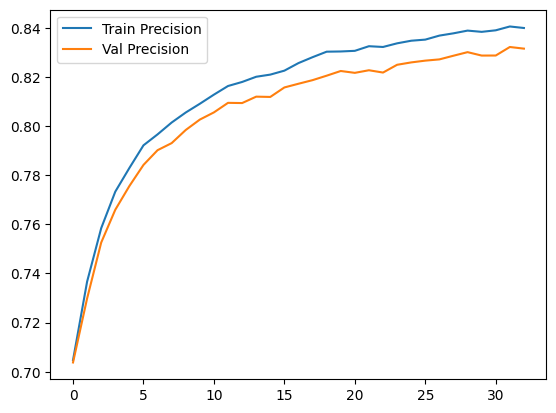

In [16]:
plt.plot(list(range(len(net_precisions_train))), net_precisions_train, label='Train Precision')
plt.plot(list(range(len(net_precisions_val))), net_precisions_val, label='Val Precision')
plt.legend()

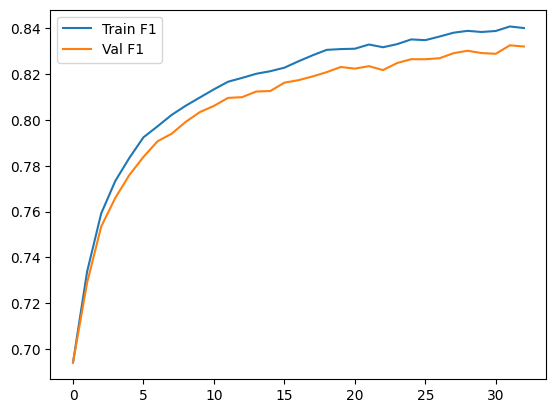

In [17]:
plt.plot(list(range(len(net_f1_train))), net_f1_train, label='Train F1')
plt.plot(list(range(len(net_f1_val))), net_f1_val, label='Val F1')
plt.legend()